## Preparation

Use dataset that is provided in the eLearning.  
This is the same dataset as in the Lab-3. Repeat the steps from Lab-3 to replace Na's with zero for numerical variables and with "Missing" for categorical. 


In [4]:
import pandas as pd
pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Load data

In [7]:
#train_df = pd.read_csv('./data/SBA_loans_small.zip')
X_train = pd.read_csv('SBA_loans_train.csv')
X_test  = pd.read_csv('SBA_loans_test.csv')
orig_columns = list(X_train.columns)

In [8]:
print(orig_columns)

['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'Defaulted']


In [11]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (337186, 20)
Test shape: (112396, 20)


## Preparation Step

This is the same dataset as in the Lab-3. Repeat the steps from Lab-3 to replace Na's with zero for numerical variables and with "Missing" for categorical. 

In [14]:
for col in X_test.columns:
    if X_test[col].isna().any() == True:
        print(col)

City
State
Bank
BankState
NewExist
RevLineCr
LowDoc


In [16]:
for col in X_train.columns:
    if X_test[col].isna().any() == True:
        print(col)

City
State
Bank
BankState
NewExist
RevLineCr
LowDoc


In [18]:
category=['City','State','Bank','BankState','RevLineCr','LowDoc']
numeric=['NewExist']
for i in category:
    X_train[i]=X_train[i].fillna("Missing")
    X_test[i]=X_test[i].fillna("Missing")
for j in numeric:
    X_train[j]=X_train[j].fillna(0)
    X_test[j]=X_test[j].fillna(0)

## Question 1 - 2 points

Consider following variables to be Categorical:
- "City" has 22070 values
- "State" has 52 values
- "Bank" has 4834 values
- "BankState" has 56 values
- "RevLineCr" has 14 values
- "LowDoc" has 8 values

Use Target and WOE encoder from the `category_encoders` library to encode categorical variables.  
Fit encoders using Training dataset only.  
For each encoder, give new columns names "Original-name"_te for target-encoder and "Original-name"_woe for WOE encoder. After encoding, your train/test dataframes will have all the original columns, plus new columns with encoded values.

In [20]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder, WOEEncoder

# Initialize dictionary to save encoders
cat_encoders = {}

# List of categorical variables
categorical_vars = ["City", "State", "Bank", "BankState", "RevLineCr", "LowDoc"]

# For each categorical variable
for var in categorical_vars:
    # Target Encoding
    te = TargetEncoder()
    te.fit(X_train[var], X_train['Defaulted'])  # Assuming 'target' is the target variable
    X_train[f"{var}_te"] = te.transform(X_train[var])
    X_test[f"{var}_te"] = te.transform(X_test[var])
    cat_encoders[(var, "te")] = te

    # WOE Encoding
    woe = WOEEncoder()
    woe.fit(X_train[var], X_train['Defaulted'])  # Assuming 'target' is the target variable
    X_train[f"{var}_woe"] = woe.transform(X_train[var])
    X_test[f"{var}_woe"] = woe.transform(X_test[var])
    cat_encoders[(var, "woe")] = woe

## Question 2 - 6 points

Review sklearn documentation on the RandomForest optimal hyper-parameters choice and methods for tuning: https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters

Train RandomForest models with the following parameters:

```
n_estimators = [50, 100, 200]
max_depth = [5,7,10]
max_features = ["sqrt", "log2", 5]
random_state = 0
max_samples = [0.2, 0.4, 0.6]
bootstrap = True
```
Don't use original categorical variables, only encoded via Target and WOE encoder.
Perform split of the Training dataset to Train and Validation datasets. Use Validation dataset to find best performing model.

Don't use Grid-Search Class by Sklearn or other library. For studying purposes, implement Grid-Search yourself.

Use F1 to find best performing model on the Validation dataset.

Use F1 score "weighted" : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html 

Once optimal hyper-parameters are found, train model on the Training dataset and evaluate on the Test dataset.  
You should evaluate model performance on the Test dataset only once, after you found optimal hyper-parameters.

Report best model (as measured by F1) hyper-parameters.
Report best model F1 and confusion matrix.

**Note**: depending on your PC resources you can increase speed of model training by specifying `n_jobs` parameter.

In [22]:
X_train_te=X_train[["City_te","State_te","Bank_te", "BankState_te", "RevLineCr_te", "LowDoc_te"]]
X_train_woe=X_train[["City_woe","State_woe","Bank_woe", "BankState_woe", "RevLineCr_woe", "LowDoc_woe"]]
y_train=X_train['Defaulted']
X_test_te=X_test[["City_te","State_te","Bank_te", "BankState_te", "RevLineCr_te", "LowDoc_te"]]
X_test_woe=X_test[["City_woe","State_woe","Bank_woe", "BankState_woe", "RevLineCr_woe", "LowDoc_woe"]]
y_test=X_test['Defaulted']


from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [26]:
# Define parameter grid (example)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5,7,10],
    'max_features' : ["sqrt", "log2", 5],
    'random_state': [0],
    'max_samples' : [0.2, 0.4, 0.6],
    'bootstrap' : [True]
}

# Function to create all combinations of parameters
def param_combinations(param_grid):
    keys, values = zip(*param_grid.items())
    return [dict(zip(keys, v)) for v in product(*values)]



In [28]:
y_train.shape,X_train_te.shape

((337186,), (337186, 6))

In [30]:
#te
x_t,x_v,y_t,y_v=train_test_split(X_train_te, y_train, test_size=0.2, random_state=0)

In [32]:
#woe
x_t_w,x_v_w,y_t_w,y_v_w=train_test_split(X_train_woe, y_train, test_size=0.2, random_state=0)

In [108]:
# Grid Search Implementation for te
best_score = 0
best_params = None
for params in param_combinations(param_grid):
    model = RandomForestClassifier(**params)
    model.fit(x_t, y_t)
    predictions = model.predict(x_v)
    score = accuracy_score(y_v, predictions)
    
    if score > best_score:
        best_score = score
        best_params = params

print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")


Best Score: 0.848542364838815
Best Parameters: {'n_estimators': 50, 'max_depth': 10, 'max_features': 5, 'random_state': 0, 'max_samples': 0.4, 'bootstrap': True}


In [126]:
# Grid Search Implementation for woe
best_score2 = 0
best_params2 = None
for params in param_combinations(param_grid):
    model2 = RandomForestClassifier(**params)
    model2.fit(x_t_w, y_t_w)
    predictions2 = model2.predict(x_v_w)
    score2 = accuracy_score(y_v_w, predictions2)
    
    if score2 > best_score2:
        best_score2 = score2
        best_params2 = params

print(f"Best Score: {best_score2}")
print(f"Best Parameters: {best_params2}")


Best Score: 0.8453394228773096
Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'max_features': 5, 'random_state': 0, 'max_samples': 0.2, 'bootstrap': True}


In [113]:
#best model using te 
best_dtc = RandomForestClassifier(**best_params)
best_dtc.fit(x_t, y_t)
predictions = best_dtc.predict(x_v)

In [36]:
best_params2={'n_estimators': 200, 'max_depth': 10, 'max_features': 5, 'random_state': 0, 'max_samples': 0.2, 'bootstrap': True}

In [38]:
#best model using woe 
best_dtc2=RandomForestClassifier(**best_params2)
best_dtc2.fit(x_t_w, y_t_w)
predictions2 = best_dtc2.predict(x_v_w)

## Question 3 - 2 Points

Calculate best model feature importances using permutation method.
Produce visualization of the best model feature importances.

In [42]:
from sklearn.inspection import permutation_importance
import numpy as np

In [120]:


# Calculate permutation importances on the test set
perm_importance = permutation_importance(best_dtc, X_test_te, y_test, n_repeats=30, random_state=0)

# Get the mean importances and standard deviations
importances_mean = perm_importance.importances_mean
importances_std = perm_importance.importances_std

# Feature names
feature_names = X_test_te.columns


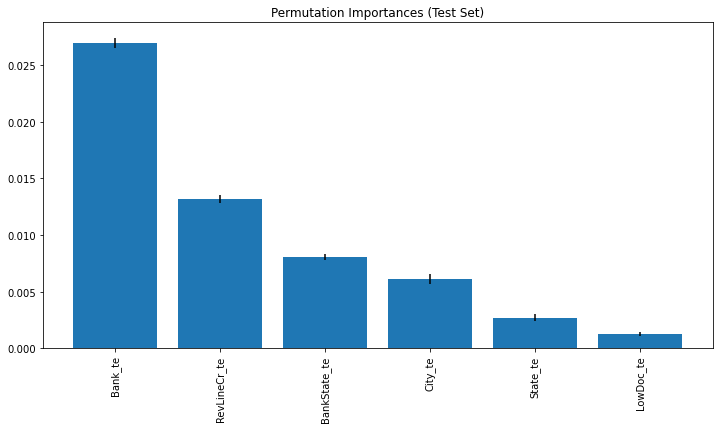

In [121]:
import matplotlib.pyplot as plt

# Sort the feature importances in descending order and get their indices
sorted_idx = np.argsort(importances_mean)[::-1]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_idx)), importances_mean[sorted_idx], yerr=importances_std[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
plt.title('Permutation Importances (Test Set)')
plt.show()

In [44]:
# Calculate permutation importances on the test set
perm_importance = permutation_importance(best_dtc2, X_test_woe, y_test, n_repeats=30, random_state=0)

# Get the mean importances and standard deviations
importances_mean = perm_importance.importances_mean
importances_std = perm_importance.importances_std

# Feature names
feature_names = X_test_woe.columns

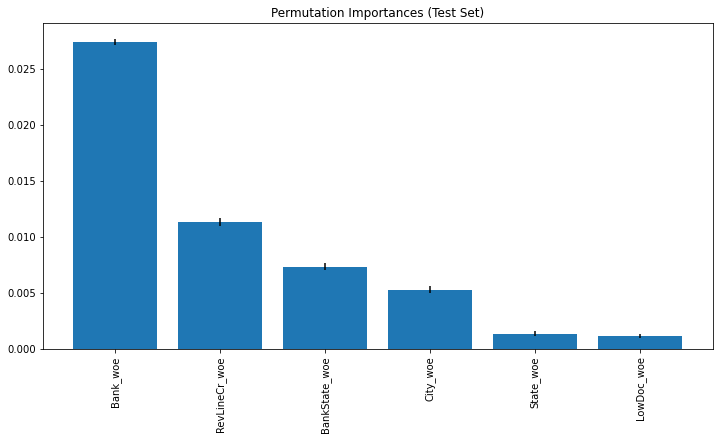

In [45]:
import matplotlib.pyplot as plt

# Sort the feature importances in descending order and get their indices
sorted_idx = np.argsort(importances_mean)[::-1]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_idx)), importances_mean[sorted_idx], yerr=importances_std[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
plt.title('Permutation Importances (Test Set)')
plt.show()